# Wingsuit Flight Motion Tracking 

## <a id=toc0></a> **content** 
  - [**1.Import Libraries**](#toc1)    
  - [**2.Load Video & Extract Frames**](#toc2)   
  -- [**2.1 Load Video**](#toc2.1)    
  -- [**2.2 Extract key video properties**](#toc2.2)    
  -- [**2.3 Extract and store frames**](#toc2.3)    
  -- [**2.4 Release and display**](#toc2.4)
  - [**3.Dynamic Motion Tracking with Optical Flow**](#toc3)     
  -- [**3.1 Define feature detection parameters**](#toc3.1)   
  -- [**3.2 Define LK optical flow parameters**](#toc3.2)     
  -- [**3.3 Track features and draw color-doded motion vectors**](#toc3.3)    
  - [**Generate & Display Animation**](#toc4)    
  - [**Acknowledgment**](#toc5)    


## <a id=toc1></a>[Import libraries](#toc0)

In [349]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import os
import time
import matplotlib.animation as animation

## <a id=toc2></a>[Load Video & Extract Frames](#toc0)

### <a id=toc2.1></a>[Load video](#toc0)

In [350]:
video_cap=cv2.VideoCapture("wingsuit flight.mp4") 

### <a id=toc2.2></a>[Extract key video properties](#toc0)

In [351]:
#Extract file size
file_size=os.path.getsize("wingsuit flight.mp4") / (1024 * 1024)  # file size in MB
#Extract dimension
frame_width = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
#Extract total frames
total_frames = int(video_cap.get(cv2.CAP_PROP_FRAME_COUNT))
#Extract fps
frame_fps=video_cap.get(cv2.CAP_PROP_FPS)
#Extract duration
duration_sec = total_frames / frame_fps if frame_fps else 0
duration_min = duration_sec / 60
#Extract codec
codec = int(video_cap.get(cv2.CAP_PROP_FOURCC))
codec_str = "".join([chr((codec >> 8 * i) & 0xFF) for i in range(4)])
#Display video properties
print(f"File Size: {file_size:.2f} MB")
print(f"Dimensions: {frame_width}x{frame_height}")
print(f"Total Frames: {total_frames}")
print(f"FPS: {frame_fps}")
print(f"Duration: {duration_min:.2f} min({duration_sec:.2f})s ")
print(f"Codec: {codec_str}")

File Size: 1.43 MB
Dimensions: 640x360
Total Frames: 92
FPS: 9.0
Duration: 0.17 min(10.22)s 
Codec: h264


### <a id=toc2.3></a>[Extract and store frames](#toc0)

In [352]:
#Extract frames
frames_ori = []
frames_gray=[]
frames_max=90
for i in range(min(frames_max,total_frames)):
    re,frame=video_cap.read()
    if not re:
        break
    frames_ori.append(frame)
    frames_gray.append(cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY))


### <a id=toc2.4></a>[Release and display](#toc0)

Extracted 90 frames.


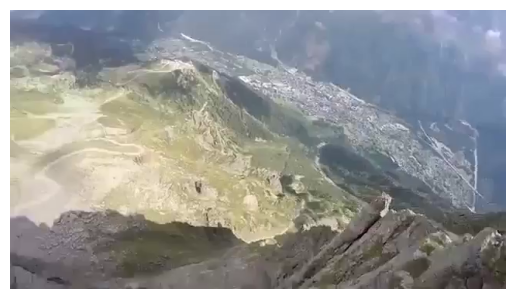

In [353]:
#Release video capture object
video_cap.release()
#Count frames
print(f"Extracted {len(frames_ori)} frames.")
#Display first frame
frames_ori[0]=cv2.cvtColor(frames_ori[0],cv2.COLOR_BGR2RGB)
plt.imshow(frames_ori[0])
plt.axis('off') 
plt.show()


## <a id=toc3></a>[Dynamic Motion Tracking with Optical Flow](#toc0)

### <a id=toc3.1></a>[Define feature detection parameters](#toc0)

In [354]:
feature_params = dict(
    maxCorners=200,        
    qualityLevel=0.01,     
    minDistance=10,        
    blockSize=15
)

### <a id=toc3.2></a>[Define LK optical flow parameters](#toc0)

In [355]:
lk_params = dict(
    winSize=(25, 25),
    maxLevel=5,
    criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01)
    )


### <a id=toc3.3></a>[Track features and draw color-doded motion vectors](#toc0)

In [356]:
#Detect features in the first frame
p0 = cv2.goodFeaturesToTrack(frames_gray[0], mask=None, **feature_params)
p0 = p0.astype(np.float32)
pre=p0
#Define a function to remove duplicate points
def remove_duplicates(existing_points, new_points, min_distance=5):
    if existing_points is None or len(existing_points) == 0:
        return new_points
    if new_points is None or len(new_points) == 0:
        return np.empty((0, 1, 2), dtype=np.float32)
    
    existing_points = existing_points.reshape(-1, 2)
    new_points = new_points.reshape(-1, 2)
    
    filtered_new_points = []
    for new_pt in new_points:
        distances = np.linalg.norm(existing_points - new_pt, axis=1)
        if np.all(distances >= min_distance):
            filtered_new_points.append(new_pt)
    
    return np.array(filtered_new_points)

track_frames=[]
for i in range(1, len(frames_gray)):
    p_cur,status,err=cv2.calcOpticalFlowPyrLK(frames_gray[i-1],frames_gray[i],pre,None,**lk_params)
    good_new=p_cur[status==1]
    good_old=pre[status==1] 
    print(f"Frame {i}: Tracked points: {len(good_new)}")
    if len(good_new)<=50 or (i+1)%5==0:
        if(len(good_new)>50):
            p_new=cv2.goodFeaturesToTrack(frames_gray[i], mask=None, **feature_params)
            if p_new is not None:
                p_new=remove_duplicates(good_new,p_new)
                good_new=np.vstack((good_new,p_new))
                if len(good_new)>200:
                    good_new=good_new[:200]
        else:
            while(len(good_new)<=50):
                p_new=cv2.goodFeaturesToTrack(frames_gray[i], mask=None, **feature_params)
                if p_new is None:
                    break
                p_new=remove_duplicates(good_new,p_new)
                if len(p_new)==0:
                    break
                good_new=np.vstack((good_new,p_new))
                if len(good_new)>200:
                    good_new=good_new[:200]
        print(f"Frame {i}: Added new points, total now: {len(good_new)}")
    frame=frames_ori[i].copy()
    #Convert to color for visualization
    for new,old in zip(good_new,good_old):
        a,b = new.ravel()
        c,d = old.ravel()
        dx=a-c
        dy=b-d
        speed=np.sqrt(dx**2+dy**2)
        if speed<5:
            color=(255,0,0)  #Blue for slow
        elif speed<15:
            color=(0,255,0) #Green for medium
        else:
            color=(0,0,255)  #Red for fast
        frame=cv2.arrowedLine(frame, (int(c),int(d)), (int(a),int(b)), color, 2, tipLength=0.3)#Draw arrowed line
    track_frames.append(frame) 
    pre=good_new.reshape(-1,1,2)

Frame 1: Tracked points: 193
Frame 2: Tracked points: 185
Frame 3: Tracked points: 151
Frame 4: Tracked points: 150
Frame 4: Added new points, total now: 200
Frame 5: Tracked points: 199
Frame 6: Tracked points: 199
Frame 7: Tracked points: 196
Frame 8: Tracked points: 192
Frame 9: Tracked points: 192
Frame 9: Added new points, total now: 200
Frame 10: Tracked points: 200
Frame 11: Tracked points: 200
Frame 12: Tracked points: 199
Frame 13: Tracked points: 196
Frame 14: Tracked points: 192
Frame 14: Added new points, total now: 200
Frame 15: Tracked points: 196
Frame 16: Tracked points: 130
Frame 17: Tracked points: 122
Frame 18: Tracked points: 83
Frame 19: Tracked points: 80
Frame 19: Added new points, total now: 200
Frame 20: Tracked points: 197
Frame 21: Tracked points: 193
Frame 22: Tracked points: 170
Frame 23: Tracked points: 120
Frame 24: Tracked points: 103
Frame 24: Added new points, total now: 200
Frame 25: Tracked points: 184
Frame 26: Tracked points: 182
Frame 27: Tracked 

## <a id=toc4></a>[Generate & Display Animation](#toc0)

In [357]:
def update(frame):   #Define update function for animation
    plt.cla()
    frame_img=cv2.cvtColor(track_frames[frame],cv2.COLOR_BGR2RGB)
    img=plt.imshow(frame_img)
    plt.axis('off' )
    plt.title(f'Frame {frame+1}\n(Red = Fast Speed, Green=Medium Speed,Blue = Slow Speed)',fontsize=16)
    return []
#Create animation
plt.close('all')
fig=plt.figure(figsize=(10,6))
ani = animation.FuncAnimation(
    fig, update,
    frames=range(len(track_frames)),
    interval=1000/frame_fps,  
    blit=True,
    repeat=True
)
display(HTML(ani.to_html5_video() ))
ani.save('Wingsuit_Analysis.mp4', fps=frame_fps,codec='libx264')# Save animation as MP4
plt.close(fig)

## <a id=toc5></a>[Acknowledgement](#toc0)

**The video footage is sourced from the YouTube video 'GoPro: Graham Dickinson's Insane Wingsuit Flight - Front Helmet Cam 2 of 3' (URL:https://www.youtube.com/watch?v=kTzwvyzzfjk). This material is used for educational purposes only, with no copyright infringement intended.**